# Prediction of toxicity of small molecules

This notebook contains a end to end project for toxicity prediction of small molecules. Specific details about the code can be found in the present notebbok or in the helper scripts referenced in each section. 

For this project the dataset used was [MolToxPred](https://pubs.rsc.org/en/content/articlelanding/2024/ra/d3ra07322j). For further information check out the linked reference.

In [1]:
import pandas as pd
from collections import Counter

In [2]:
data = pd.read_csv('data/Data_toxicity.csv')
data.head()

,SMILES,Toxicity
0,Cn1cnc2c(F)c(Nc3ccc(Br)cc3Cl)c(C(=O)NOCCO)cc21,0
1,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,0
2,CN(C)C/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2...,0
3,COC1CC2CCC(C)C(O)(O2)C(=O)C(=O)N2CCCCC2C(=O)OC...,0
4,CS(=O)(=O)O.Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc...,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10449 entries, 0 to 10448
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   SMILES    10449 non-null  object
 1   Toxicity  10449 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 163.4+ KB


In [4]:
print(data['Toxicity'].value_counts())

Toxicity
0    5833
1    4616
Name: count, dtype: int64


In [5]:
mol_counts = Counter(data['SMILES'])
duplicates = {element: count for element, count in mol_counts.items() if count > 1}
print(duplicates)

{}


This is a dataset containig 10449 compounds. There is a small imbalance as 5833 of the molecules are non-toxic (label 0), while the remaining 4616 are toxic (label 1)

## Standardization of the compounds

**NOTE: This section of the project is based on [DeepMol](https://deepmol.readthedocs.io/en/latest/) standardization tutorial and [MolPipeline](https://pubs.acs.org/doi/10.1021/acs.jcim.4c00863) example notebooks with some minor modifications.**

Standardization referes to transforming a set of chemical structures to a standardized format using a predifined set of rules. This allows to properly compare the chemical structures in the dataset to each other and handle steps like duplicated element deletion or ensure data consistency. 

There are 3 common standardization options: basic standardizer, complex standardizerand ChEMBL standardizer. Simple standardizer only perform sanititization, including steps like kekulize, check valencies, set aromaticity, conjugation and hybridization. Complex standardizers include customized procedures by performing additional steps like remove isotope information, neutralize charges, remove stereochemistry or remove smaller fragments. Finally, [ChEMBL](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00456-1) standardizer formats compounds according to defined rules and conventions.

In [2]:
from molpipeline import Pipeline
from molpipeline.any2mol import AutoToMol
from molpipeline.mol2mol import ElementFilter, MetalDisconnector, SaltRemover, StereoRemover, SolventRemover, TautomerCanonicalizer, Uncharger

In [7]:
#Create elements from smiles
mol_from_smiles = [('auto2mol', AutoToMol())]

#Set up the molecular standardization steps
standardization_steps = [
    ('metal_disconnector', MetalDisconnector()),
    ('salt_remover', SaltRemover()),
    ('element_filter', ElementFilter()),
    ('uncharge', Uncharger()),
    ('canonical_tautomer', TautomerCanonicalizer()),
    ('stereo_remover', StereoRemover())
]

pipeline_standardization = Pipeline(
    mol_from_smiles + standardization_steps
)

standardized_structures = pipeline_standardization.transform(data['SMILES'])

The above pipeline, in the standardization steps, include the following procedures:
   
1. `metal_disconnector`: remove metal atoms. Disconnecting metal ensures that the core organic molecules are properly analyzed as metals re not well-represented in cheminformatics.

2. `salt_remover`: Removes salt counterions (e.g., Na+, Cl-, K+) from the molecule. These ions are often added during synthesis or purification but are not part of the active molecule. These salts can artificially inflate the molecular weight or alter properties like solubility, leading to incorrect predictions and are irrelevant to the biological activity.

3. `element_filter`: In this step molecules containing elements other than the default elements (H, B, C, O, F, Si, P, S, Cl, Se, Br, I) are replaced with an `InvalidInstance` to instead of removing it and avoid inconsistencies with the initial input. This element filter is needed to avoid feature representation problems as unusual elements may not be properly encoded, they may also introduce noise or irrelevant patterns, and disturb the capacity of the model to capture meaningful biological information. **It is important to apply this filter only after disconnecting metals aor removing salts to avoid removing compounds of interest**

5. `uncharge`: Neutralizes charged molecules by adjusting protonation states (e.g., converting -COO⁻ to -COOH or -NH₃⁺ to -NH₂). Charged molecules can have different physicochemical properties (e.g., solubility, reactivity) compared to their neutral forms. Uncharging ensures consistency in molecular representation.

6. `canonical_tautomer`: Converts the molecule to a standardized tautomeric form. Tautomers are isomers that can interconvert by the movement of a proton and a double bond (e.g., keto-enol tautomerism). Tautomers can have different chemical properties, but they represent the same molecule in equilibrium. Without standardization, the same molecule could be represented in multiple ways, leading to inconsistencies in predictions, affecting the model reliability.

7. `stereo_remover`: Removes stereochemical information (e.g., chiral centers, double bond stereochemistry) from the molecule. Stereochemistry can significantly affect molecular properties (e.g., biological activity), but if only a part of the training data include stereochemistry, considering it in the input can lead to incorrect predictions.

Additional standardazation steps can be added. Chech [RDKit standardization module documentation](https://www.rdkit.org/docs/source/rdkit.Chem.MolStandardize.html) or [MolVS documentation](https://molvs.readthedocs.io/en/latest/guide/standardize.html). Also, you can check this talk from [Greg Landrum](https://www.youtube.com/watch?v=eWTApNX8dJQ)

**Note: every standardization step must be carefully selected to avoid overcleaning the data and affecting the predictive power of the model**

In [8]:
data ['Standardized_structure'] = standardized_structures
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10449 entries, 0 to 10448
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   SMILES                  10449 non-null  object
 1   Toxicity                10449 non-null  int64 
 2   Standardized_structure  10449 non-null  object
dtypes: int64(1), object(2)
memory usage: 245.0+ KB


In [9]:
structure_counts = Counter(data['Standardized_structure'])
duplicates_structure = {structure: count for structure, count in structure_counts.items() if count > 1}
print(duplicates_structure)

{InvalidInstance(ElementFilter, Molecule contains forbidden chemical element.): 838, InvalidInstance(TautomerCanonicalizer, Tautomer enumeration failed.: Invariant Violation
	could not find atom2
	Violation occurred on line 228 in file Code/GraphMol/Canon.cpp
	Failed Expression: firstFromAtom2
	RDKIT: 2023.09.6
	BOOST: 1_78
): 4}


For the porpuse of this project, after completing the standardization these molecular structures (up to this point stored as mol objects) should be converted to a canonical smiles. This is necessary because after standadization some structures were manipulated and cleaned and therefore the smiles will changed. Also, this is required for the feature extraction step when using Large Language Models (see next section). This canonicalization also guarantees that the smiles are unique and avoids the presence of duplicated structures. However, every toolkit, and sometimes different versions of the same software, different algorithm. Therefore, **the uniqueness of the canonical smiles can only be ensured by using the same tool and version if this step is required in the future.**

In [10]:
import rdkit
from rdkit import Chem
import numpy as np

In [11]:
print("RDKit version:", rdkit.__version__)

RDKit version: 2023.09.6


In [12]:
def mol_to_smiles(mol):
    """
    Converts an RDKit molecule object to its canonical SMILES representation.

    Parameters:
    -----------
    mol : rdkit.Chem.rdchem.Mol
        An RDKit molecule object to be converted to a SMILES string.

    Returns:
    --------
    canonical_smiles : str or np.nan
        The canonical SMILES string corresponding to the input molecule.
        If the conversion fails (e.g., due to an invalid molecule), `np.nan` is returned.
    """
    try:
        canonical_smiles = Chem.MolToSmiles(mol)
    except Exception as e:
        # If an error occurs (e.g., invalid molecule), return Na
        canonical_smiles = np.nan

    return canonical_smiles

In [13]:
canonical_smiles = [mol_to_smiles(mol) for mol in data['Standardized_structure']]
data ['Canonical_smiles'] = canonical_smiles
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10449 entries, 0 to 10448
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   SMILES                  10449 non-null  object
 1   Toxicity                10449 non-null  int64 
 2   Standardized_structure  10449 non-null  object
 3   Canonical_smiles        9607 non-null   object
dtypes: int64(1), object(3)
memory usage: 326.7+ KB


Finally, after the canonicalization the invalid entries (837) are removed from the dataset keeping both the canonical smiles and the mol objects for practical porpuses in the next step.

In [14]:
cleaned_data = data.dropna().reset_index(drop=True)
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9607 entries, 0 to 9606
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   SMILES                  9607 non-null   object
 1   Toxicity                9607 non-null   int64 
 2   Standardized_structure  9607 non-null   object
 3   Canonical_smiles        9607 non-null   object
dtypes: int64(1), object(3)
memory usage: 300.3+ KB


In [15]:
cleaned_data.head()

,SMILES,Toxicity,Standardized_structure,Canonical_smiles
0,Cn1cnc2c(F)c(Nc3ccc(Br)cc3Cl)c(C(=O)NOCCO)cc21,0,<rdkit.Chem.rdchem.Mol object at 0x148ce0746e80>,Cn1cnc2c(F)c(Nc3ccc(Br)cc3Cl)c(C(=O)NOCCO)cc21
1,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,0,<rdkit.Chem.rdchem.Mol object at 0x148ce0747420>,COC(=O)c1ccc2c(C(=Nc3ccc(N(C)C(=O)CN4CCN(C)CC4...
2,CN(C)C/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2...,0,<rdkit.Chem.rdchem.Mol object at 0x148ce0747970>,CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc...
3,COC1CC2CCC(C)C(O)(O2)C(=O)C(=O)N2CCCCC2C(=O)OC...,0,<rdkit.Chem.rdchem.Mol object at 0x148ce0747fb0>,COC1CC2CCC(C)C(O)(O2)C(=O)C(=O)N2CCCCC2C(=O)OC...
4,CS(=O)(=O)O.Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc...,0,<rdkit.Chem.rdchem.Mol object at 0x148ce07584a0>,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...


In [16]:
from ipywidgets import interact, fixed 
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

mols = cleaned_data['Standardized_structure']

@interact(idx=range(0, len(mols)), ms=fixed(mols))
def show_mol(idx, ms):
    d2d = rdMolDraw2D.MolDraw2DSVG(450, 400)
    d2d.drawOptions().prepareMolsBeforeDrawing=False
    d2d.DrawMolecule(ms[idx])
    d2d.FinishDrawing()
    return SVG(d2d.GetDrawingText())

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

In [17]:
cleaned_data.to_csv('data/cleaned_data.csv', index=False)

## Data splitting

Before moving forward the data needs to be splitted into three different datasets: train, validation and test


![split_image.png](https://cdn-images-1.medium.com/fit/t/1600/480/1*4G__SV580CxFj78o9yUXuQ.png)

The splitting was done with the ``` similartySplitter()``` function of DeepMol. 

Run the script ``` similartysplitter.py```

In [2]:
train = pd.read_csv('data/train_data.csv')
validation = pd.read_csv('data/validation_data.csv')
test = pd.read_csv('data/test_data.csv')

[14:43:38] WARNING: not removing hydrogen atom without neighbors
[14:43:38] WARNING: not removing hydrogen atom without neighbors
[14:43:38] WARNING: not removing hydrogen atom without neighbors
[14:43:38] WARNING: not removing hydrogen atom without neighbors


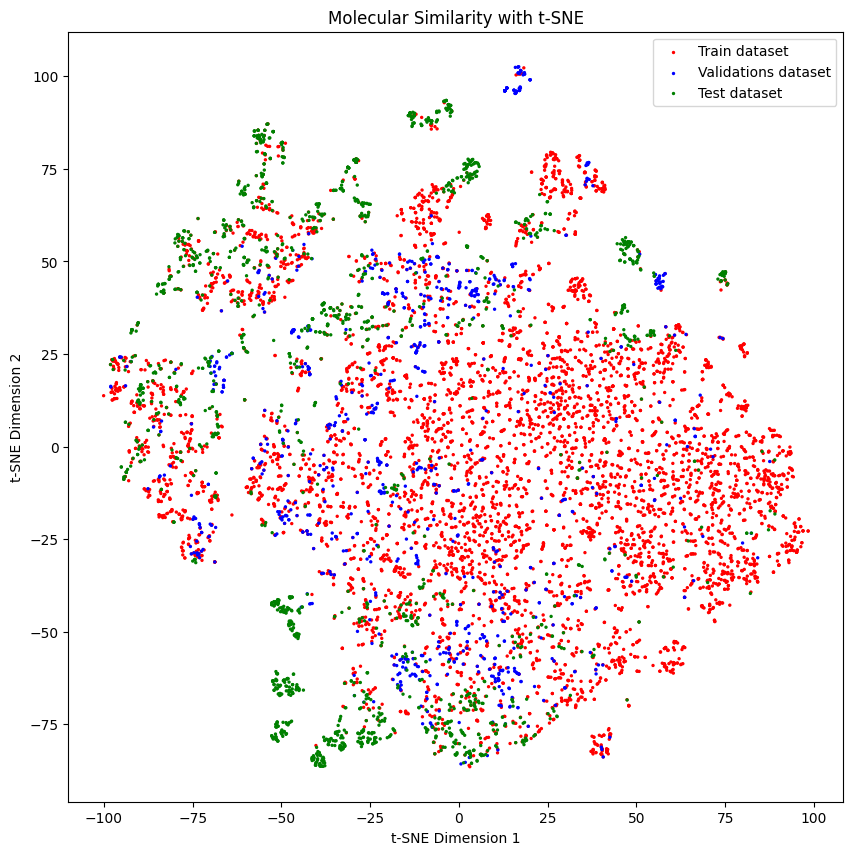

In [19]:
from src.similarity_plot import PlotSimilarity

plotter = PlotSimilarity(train, validation, test)
plotter.generate_tsne_molecular_similarities('Canonical_smiles')

It can be observed taht the train and test dataset are different in terms of similarity. This guarantees a more objective assesment of the performance of the models trained with the dataset and avoids data leakage (commom when using random splitting) as it can be seen in the image below.

![random.png](https://deepmol.readthedocs.io/en/latest/_images/splitters_40_1.png)

## Molecular respresentation

**NOTE: This section of the project is based on [DeepMol](https://deepmol.readthedocs.io/en/latest/) featurization tutorial, [MolPipeline](https://pubs.acs.org/doi/10.1021/acs.jcim.4c00863) example notebooks and [Fernandez-Torras et al.](https://www.sciencedirect.com/science/article/pii/S1367593121001204#fig1) with some modifications.**

![features_image.png](https://ars.els-cdn.com/content/image/1-s2.0-S1367593121001204-gr1_lrg.jpg)

Extracting features from molecules is a common task in machine learning and can be divided into classical methods and data driven methods. 

**Classical Methods**: There are 4 different types of features: 0D, 1D, 2D, 3D, or 4D.
 
- 0D features are descriptors that describe the individual parts of the molecule together as a whole, such as the number of atoms, bond counts or the molecular weight.
- 1D features are descriptors that describe substructures in the molecule (e.g. molecular fingerprints).
- 2D features are descriptors that describe the molecular topology based on the graph representation of the molecules, e.g. the number of rings or the number of rotatable bonds.
- 3D features are descriptors geometrical descriptors that describe the molecule as a 3D structure.
- 4D features are descriptors that describe the molecule as a 4D structure. A new dimension is added to characterize the interactions between the molecule and the active site of a receptor or the multiple conformational states of the molecule, e.g. the molecular dynamics of the molecule.
 
Source : [Molecular Descriptors for Structure–Activity Applications: A Hands-On Approach](https://link.springer.com/protocol/10.1007/978-1-4939-7899-1_1)
 
Calculating 3D features requires the generation of 3D conformers, which can be computationally expensive for large molecules. In addition, some features may not be available for certain molecules, e.g. 3D features cannot be calculated for molecules that do not have a 3D structure. Some tools like DeepMol provide methods for generating compound 3D structures.

**Data driven methods**: These are descriptors based on deep learning, pretrained models and LLMs strategies that encode molecules into abstract latent spaces, representing molecular similarities as simple distance measures between numerical vectors. Furthermore, molecular descriptors have expanded beyond chemistry, integrating relevant biological data from heterogeneous bioactivity assays. 

There is currently a huge amount of these methods comming out every day. This work of [The WhiteLab](https://pubs.rsc.org/en/content/articlelanding/2025/sc/d4sc03921a) presents a critical review of these tools depending on the case. In this tutorial we will use MolFormer, MolBERT, and ChemBERTa as they are the state of the art encoding methods for property prediction.

To calculate fingerprints MolPipeline offers ready pipelines to calculate Morgan fingerprints, MACCs and physicochemical descriptors. For the purpose of this project the fingerprint and MACCS will be calculated, and the only and demo of the physicochemical descriptors will be calculated.

In [4]:
from molpipeline.mol2any import MolToMorganFP, MolToMACCSFP, MolToRDKitPhysChem

In [21]:
%%time
pipeline_morgan = Pipeline(
    [
        ('auto2mol', AutoToMol()),
        ('morgan2_2048', MolToMorganFP(n_bits=1024, radius=2, return_as='dense'))
    ]
)

morgan_matrix_train = pipeline_morgan.transform(train['Canonical_smiles'])
morgan_matrix_validation = pipeline_morgan.transform(validation['Canonical_smiles'])
morgan_matrix_test = pipeline_morgan.transform(test['Canonical_smiles'])


CPU times: user 1.15 s, sys: 14 μs, total: 1.15 s
Wall time: 1.15 s


In [22]:
morgan_train = pd.DataFrame(morgan_matrix_train)
morgan_validation = pd.DataFrame(morgan_matrix_validation)
morgan_test = pd.DataFrame(morgan_matrix_test)

In [23]:
%%time
pipeline_maccs= Pipeline(
    [
        ('auto2mol', AutoToMol()),
        ('maccs', MolToMACCSFP(return_as='dense'))
    ],
)

MACCS_matrix_train = pipeline_maccs.transform(train['Canonical_smiles'])
MACCS_matrix_validation = pipeline_maccs.transform(validation['Canonical_smiles'])
MACCS_matrix_test = pipeline_maccs.transform(test['Canonical_smiles'])
 

CPU times: user 7 s, sys: 12 μs, total: 7 s
Wall time: 7 s


In [24]:
MACCS_train = pd.DataFrame(MACCS_matrix_train)
MACCS_validation = pd.DataFrame(MACCS_matrix_validation)
MACCS_test = pd.DataFrame(MACCS_matrix_test)

To use large language models to encode the smiles the [featurization module](https://github.com/FabioHerrera97/Cheminformatics_ML_toxicity/blob/main/code_and_notebooks/featurization.py) takes as input the list of smiles, the HuggingFace ID if the model, and the embedding size and retrieve a dataframe with the respective embedding. 

In [3]:
from src.featurization import LLMsEncoding

[ChemBERTa-2](https://arxiv.org/abs/2209.01712) is a transformer-based deep learning model fine-tuned for chemistry-related tasks, built on the RoBERTa architecture. It features 12 layers, 768 hidden dimensions, and 12 attention heads, totaling around 86 million parameters, optimized for processing chemical text and SMILES (Simplified Molecular Input Line Entry System) strings. The model was trained on a large-scale dataset comprising 10 million chemical compounds from PubChem, patents, research papers, and chemical reaction databases, ensuring broad coverage of organic and medicinal chemistry. Pretraining involved masked language modeling (MLM) on SMILES strings and chemical text, enabling robust molecular property prediction, reaction outcome forecasting, and chemical named entity recognition. 

In [4]:
%%time
chemberta_train = LLMsEncoding.featurize(train['Canonical_smiles'], 'DeepChem/ChemBERTa-77M-MTR', 600)
chemberta_validation = LLMsEncoding.featurize(validation['Canonical_smiles'], 'DeepChem/ChemBERTa-77M-MTR', 600)
chemberta_test = LLMsEncoding.featurize(test['Canonical_smiles'], 'DeepChem/ChemBERTa-77M-MTR', 600)

2025-05-27 10:31:11.577893: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 10:31:11.603539: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-27 10:31:11.603560: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-27 10:31:11.604268: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-27 10:31:11.608513: I tensorflow/core/platform/cpu_feature_guar

CPU times: user 4min 54s, sys: 420 ms, total: 4min 55s
Wall time: 29.3 s


[MolFormer](https://www.nature.com/articles/s42256-022-00580-7) is a transformer-based deep learning model specifically designed for molecular property prediction and drug discovery. Built on a rotary position embedding (RoPE) architecture, MolFormer efficiently processes SMILES strings and molecular graphs by capturing long-range dependencies and structural patterns. The model features 12 to 24 transformer layers, 512 to 1024 hidden dimensions, and multiple attention heads, with variants ranging from 50 million to over 100 million parameters. It was pretrained on a massive dataset of 1.1 billion molecules from the ZINC15 and PubChem databases, using masked language modeling (MLM) and contrastive learning to enhance molecular representation. MolFormer excels in tasks such as property prediction, virtual screening, and molecular optimization.

In [28]:
%%time
molformer_train = LLMsEncoding.featurize(train['Canonical_smiles'], 'ibm/MolFormer-XL-both-10pct', 2362)
molformer_validation = LLMsEncoding.featurize(validation['Canonical_smiles'], 'ibm/MolFormer-XL-both-10pct', 2362)
molformer_test = LLMsEncoding.featurize(test['Canonical_smiles'], 'ibm/MolFormer-XL-both-10pct', 2362)

100%|██████████| 1913/1913 [00:46<00:00, 41.42it/s]


CPU times: user 47min 40s, sys: 2.19 s, total: 47min 43s
Wall time: 4min 9s


[SelFormer](https://arxiv.org/abs/2304.04662) is a transformer-based deep learning model specifically optimized for self-supervised molecular representation learning, combining the strengths of SMILES-based and graph-based approaches for enhanced chemical property prediction. Built on a modified RoBERTa architecture, SelFormer integrates rotary position embeddings (RoPE) and graph attention mechanisms to capture both sequential and structural molecular features. The model typically consists of 12–16 transformer layers, 768–1024 hidden dimensions, and 12–16 attention heads, with parameter counts ranging from 50 million to over 100 million depending on configuration. It was pretrained on a diverse dataset of over 1 billion molecules from PubChem and ChEMBL, using a combination of masked language modeling (MLM), contrastive learning, and multi-task self-supervised objectives to improve generalization. SelFormer excels in low-data regimes, demonstrating strong performance in molecular property prediction.

In [37]:
%%time
selformer_train = LLMsEncoding.featurize(train['Canonical_smiles'], 'HUBioDataLab/SELFormer', 800)
selformer_validation = LLMsEncoding.featurize(validation['Canonical_smiles'], 'HUBioDataLab/SELFormer', 800)
selformer_test = LLMsEncoding.featurize(test['Canonical_smiles'], 'HUBioDataLab/SELFormer', 800)

100%|██████████| 1913/1913 [00:38<00:00, 49.18it/s]


CPU times: user 40min 46s, sys: 1.82 s, total: 40min 48s
Wall time: 3min 33s


It can be observed that the calculation of LLM based encoders require more time and computer power compater to classical methods. However, it is also important to mention that unlike convetional methods, LLMs can easily be configured to run on GPU which can significantly accelerate the calculation.

Further information regarding regarding other featurization methods can be found in [DeepMol featurization tutorial](https://deepmol.readthedocs.io/en/latest/) and [DeepChem tutorials](https://deepchem.io/tutorials/the-basic-tools-of-the-deep-life-sciences/)

## Machine Learning Modeling

The nex step is selecting several ML models for an initial screening. The selected algorithms were Random Forest, Logistic Regression, and a Deep Neural Network. Random Forest is a robust ensemble method that handles high-dimensional datasets well and is resistant to overfitting. Logistic Regression is a well-suited algorithm for binary classification, especially useful when the features have a linear relationship with the target variable. Deep Neural Networks (DNNs), on the other hand, can capture complex nonlinear patterns in the data, making them well-suited for learning intricate relationships. 

Due to time constrain the model exploration in this tutorial will be performed only once. However, it is adviced to repeat this process up to 50 times. Repeating the train–validation partitioning multiple times (e.g., 50 times) before hyperparameter optimization provides a more reliable and unbiased evaluation of model performance. This approach, often referred to as repeated holdout validation or repeated random sub-sampling, helps reduce the variance introduced by a single train–validation split, which might accidentally favor one model due to a lucky partitioning of the data. By averaging performance metrics over many repetitions, you obtain a more robust estimate of each model’s generalization ability and can better identify which algorithm consistently performs best across different data configurations. This ensures that the model selected for hyperparameter optimization is not only high-performing but also stable and less sensitive to data variability, ultimately leading to more trustworthy and generalizable results when deployed on unseen data.

In [30]:
from src.modeling import TrainerConvModel

In [40]:
def train_all_models(train_features, val_features, feature_name):
    trainer = TrainerConvModel(
        train_features, 
        train['Toxicity'], 
        val_features, 
        validation['Toxicity']
    )
    return {
        'rf': trainer.train_random_forest(),
        'lr': trainer.train_logistic_regression(),
        'dnn': trainer.train_dnn()
    }

In [45]:
import warnings
warnings.filterwarnings("ignore")

feature_sets = {
    'morgan': (morgan_train, morgan_validation),
    'MACCS': (MACCS_train, MACCS_validation),
    'chemberta': (chemberta_train, chemberta_validation),
    'molformer': (molformer_train, molformer_validation),
    'selformer': (selformer_train, selformer_validation)
}

all_results = {name: train_all_models(*features, name) 
              for name, features in feature_sets.items()}

# Morgan
(y_pred_rf_morgan, y_proba_rf_morgan) = all_results['morgan']['rf']
(y_pred_lr_morgan, y_proba_lr_morgan) = all_results['morgan']['lr']
(y_pred_dnn_morgan, y_proba_dnn_morgan) = all_results['morgan']['dnn']

# MACCS
(y_pred_rf_MACCS, y_proba_rf_MACCS) = all_results['MACCS']['rf']
(y_pred_lr_MACCS, y_proba_lr_MACCS) = all_results['MACCS']['lr']
(y_pred_dnn_MACCS, y_proba_dnn_MACCS) = all_results['MACCS']['dnn']

# ChemBERTa
(y_pred_rf_chemberta, y_proba_rf_chemberta) = all_results['chemberta']['rf']
(y_pred_lr_chemberta, y_proba_lr_chemberta) = all_results['chemberta']['lr']
(y_pred_dnn_chemberta, y_proba_dnn_chemberta) = all_results['chemberta']['dnn']

# MolFormer
(y_pred_rf_molformer, y_proba_rf_molformer) = all_results['molformer']['rf']
(y_pred_lr_molformer, y_proba_lr_molformer) = all_results['molformer']['lr']
(y_pred_dnn_molformer, y_proba_dnn_molformer) = all_results['molformer']['dnn']

# SelFormer
(y_pred_rf_selformer, y_proba_rf_selformer) = all_results['selformer']['rf']
(y_pred_lr_selformer, y_proba_lr_selformer) = all_results['selformer']['lr']
(y_pred_dnn_selformer, y_proba_dnn_selformer) = all_results['selformer']['dnn']

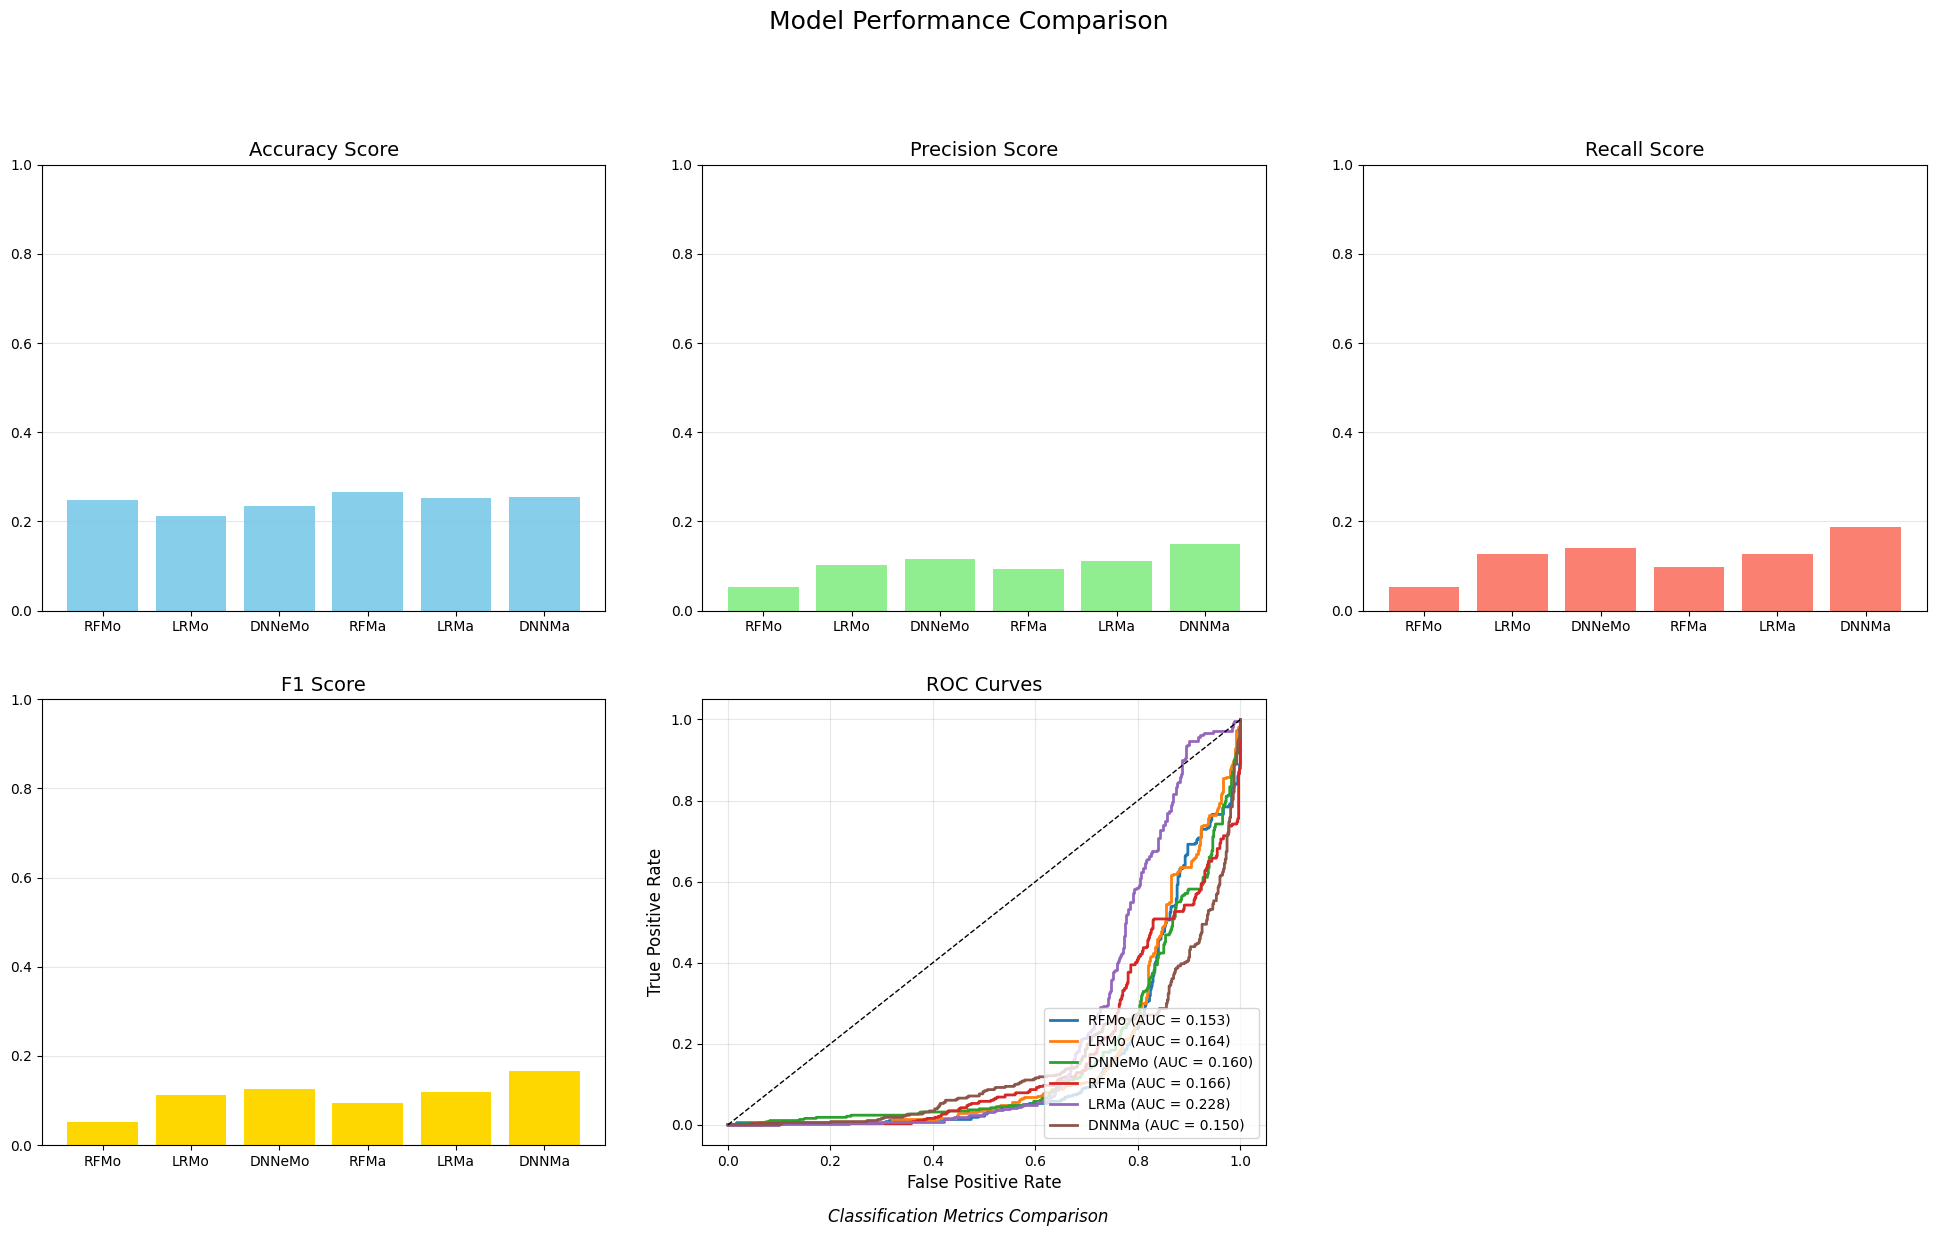

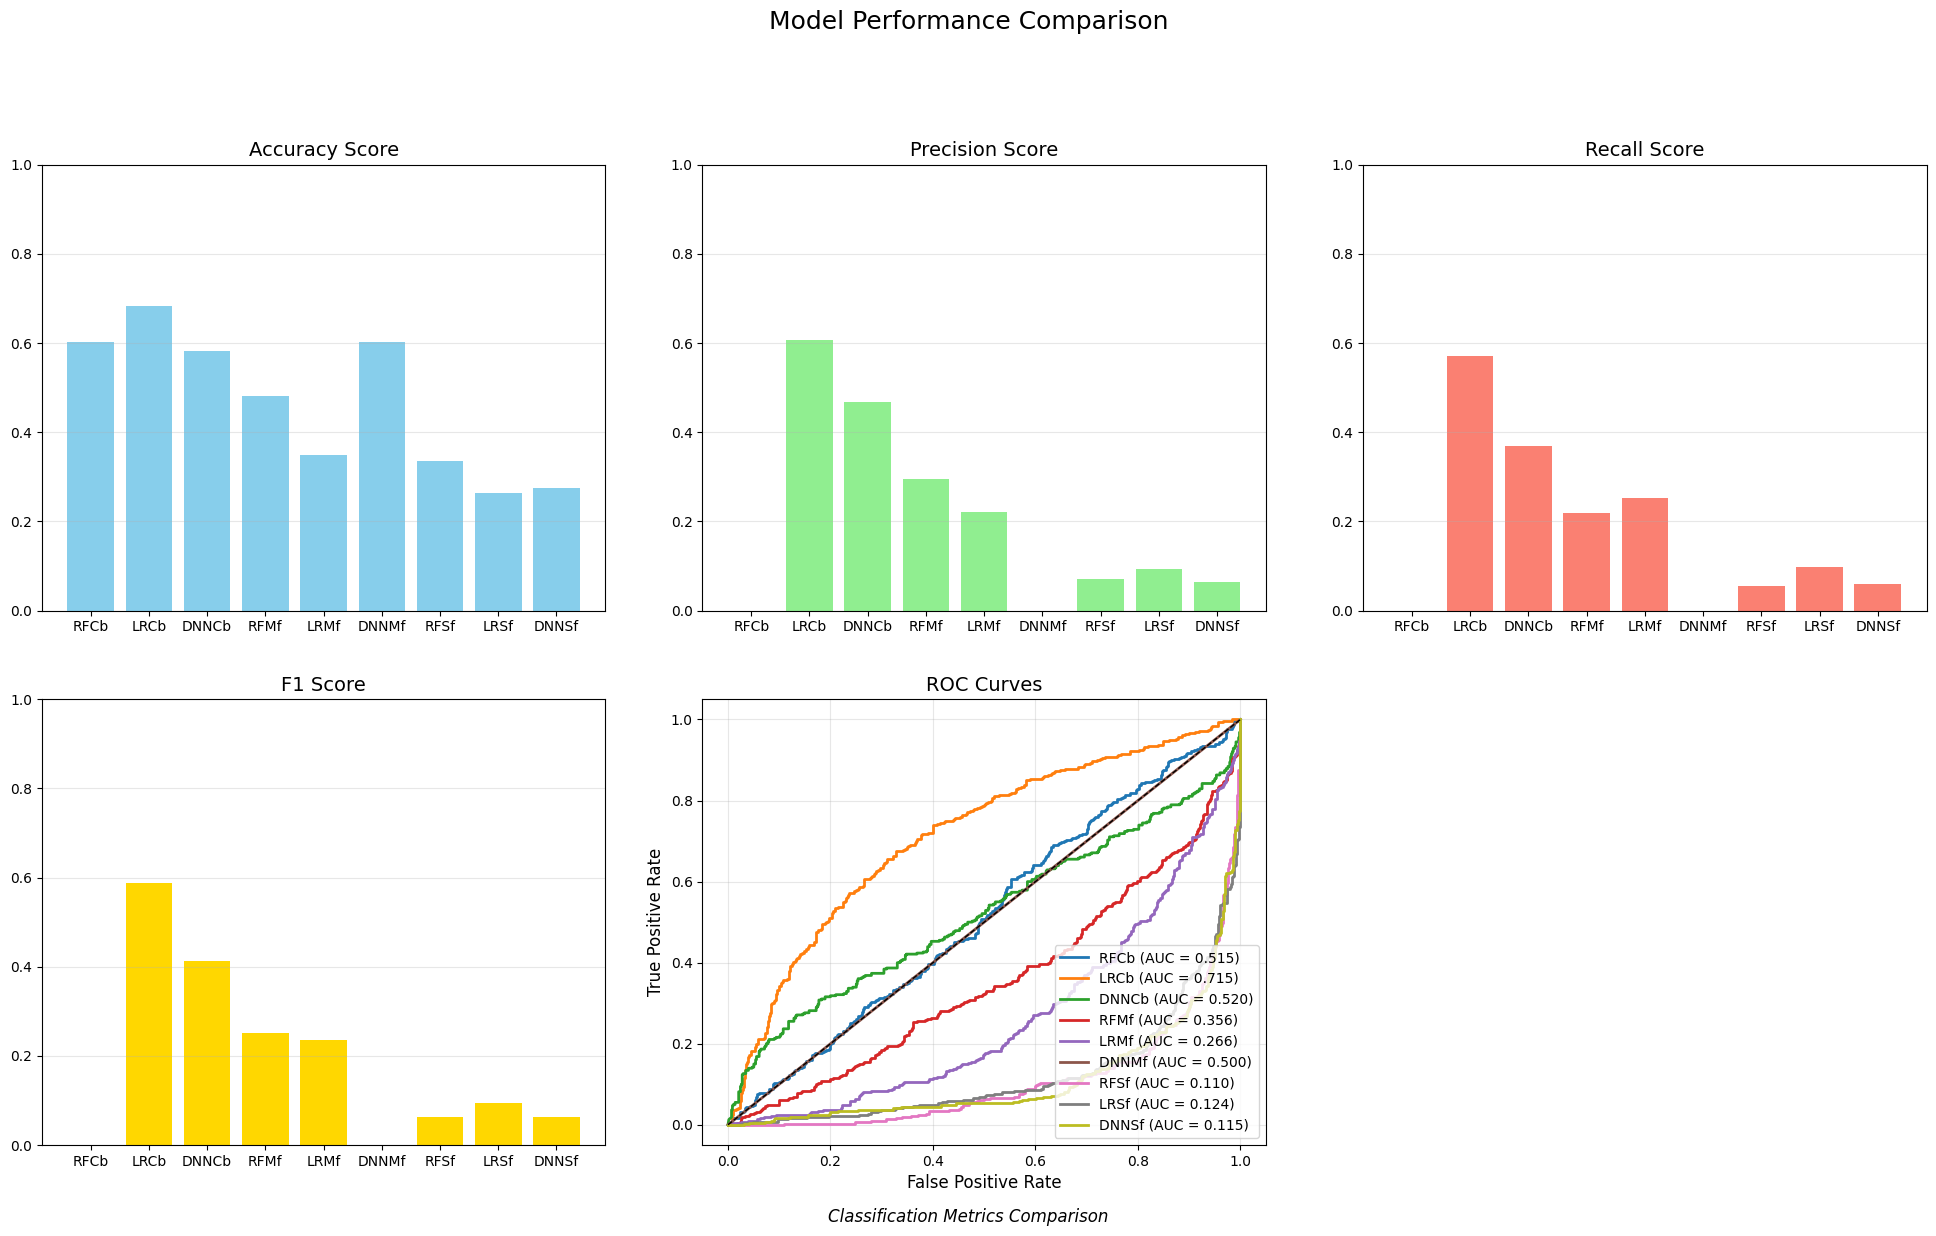

In [44]:
from src.plot_evaluation import PlotEvaluation

import warnings
warnings.filterwarnings("ignore")

plots_config = [
    {
        "preds": [y_pred_rf_morgan, y_pred_lr_morgan, y_pred_dnn_morgan, 
                  y_pred_rf_maccs, y_pred_lr_maccs, y_pred_dnn_maccs],
        "probas": [y_proba_rf_morgan, y_proba_lr_morgan, y_proba_dnn_morgan,
                   y_proba_rf_maccs, y_proba_lr_maccs, y_proba_dnn_maccs],
        "labels": ['RFMo', 'LRMo', 'DNNeMo', 'RFMa', 'LRMa', 'DNNMa']
    },
    {
        "preds": [y_pred_rf_chemberta, y_pred_lr_chemberta, y_pred_dnn_chemberta, 
                  y_pred_rf_molformer, y_pred_lr_molformer, y_pred_dnn_molformer,
                  y_pred_rf_selformer, y_pred_lr_selformer, y_pred_dnn_selformer],
        "probas": [y_proba_rf_chemberta, y_proba_lr_chemberta, y_proba_dnn_chemberta,
                   y_proba_rf_molformer, y_proba_lr_molformer, y_proba_dnn_molformer,
                   y_proba_rf_selformer, y_proba_lr_selformer, y_proba_dnn_selformer],
        "labels": ['RFCb', 'LRCb', 'DNNCb', 'RFMf', 'LRMf', 'DNNMf', 'RFSf', 'LRSf', 'DNNSf']
    }
]

for config in plots_config:
    plotter = PlotEvaluation(validation['Toxicity'], config["preds"], config["probas"], config["labels"])
    plotter.plot_metrics()

It can be observed that the Large Language Models widely outperforme teh fingerprint based representations. The ChemBERTa-2 representation in combination both with Logistic Regression and a Deep Neural Network. These 2 combinations ouperforme the other algorithms-LLMs combinations in most metrics. These 2 combinations were selected for hyperparameter optimization.

## Hyperparameter optimization

For hyperparameter optimization we will use optuna. Optuna uses Tree-structured Parzen Estimator (TPE), a Bayesian optimization method, to intelligently explore the hyperparameter space. Unlike grid or random search, it focuses on promising regions, reducing the number of trials needed to find optimal configurations. By modeling the probability distribution of high-performing hyperparameters, Optuna dynamically adjusts its search strategy, prioritizing areas that are more likely to yield better results. This leads to faster convergence compared to brute-force methods.

In [47]:
from src.hyperparameter_optimization import LogisticRegressionOptuna, DNNOptuna

# Logistic Regression
lr_opt = LogisticRegressionOptuna(chemberta_train, train['Toxicity'], chemberta_validation, validation['Toxicity'])
y_pred_lr, y_proba_lr = lr_opt.optimize(n_trials=50)

# DNN
dnn_opt = DNNOptuna(chemberta_train, train['Toxicity'], chemberta_validation, validation['Toxicity'])
y_pred_dnn, y_proba_dnn = dnn_opt.optimize(n_trials=50)


[I 2025-05-26 18:50:49,249] A new study created in memory with name: no-name-4db930d3-d9ee-431d-8c0c-7d846935ca3a
[I 2025-05-26 18:51:00,182] Trial 0 finished with value: 0.6033409610983982 and parameters: {'C': 0.0283896715689753, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 0 with value: 0.6033409610983982.
[I 2025-05-26 18:51:06,656] Trial 1 finished with value: 0.6775560640732264 and parameters: {'C': 1.0553050737647605, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 1 with value: 0.6775560640732264.
[I 2025-05-26 18:51:13,196] Trial 2 finished with value: 0.7200045766590388 and parameters: {'C': 1.5547047782071506, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 2 with value: 0.7200045766590388.
[I 2025-05-26 18:51:15,914] Trial 3 finished with value: 0.6695102974828375 and parameters: {'C': 0.243211398892165, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 2 with value: 0.7200045766590388.
[I 2025-05-26 18:51:19,447] Trial 4 finished with value: 0.59401

Best params: {'C': 2.0021859860317472, 'penalty': 'l2', 'solver': 'liblinear'}


[I 2025-05-26 18:57:06,721] A new study created in memory with name: no-name-486e3dbe-61d7-4c12-a07e-0ee89a96aab3
[I 2025-05-26 18:57:10,786] Trial 0 finished with value: 0.6405537757437071 and parameters: {'n_layers': 1, 'n_units_l0': 241, 'dropout': 0.33764248310662676, 'lr': 0.0023167533993592557, 'batch_size': 32}. Best is trial 0 with value: 0.6405537757437071.
[I 2025-05-26 18:57:13,012] Trial 1 finished with value: 0.6309519450800916 and parameters: {'n_layers': 1, 'n_units_l0': 220, 'dropout': 0.14258834246682728, 'lr': 0.0002411283908871735, 'batch_size': 128}. Best is trial 0 with value: 0.6405537757437071.
[I 2025-05-26 18:57:18,567] Trial 2 finished with value: 0.613441647597254 and parameters: {'n_layers': 3, 'n_units_l0': 108, 'n_units_l1': 198, 'n_units_l2': 144, 'dropout': 0.22101493442512338, 'lr': 0.00031578515394145926, 'batch_size': 32}. Best is trial 0 with value: 0.6405537757437071.
[I 2025-05-26 18:57:23,263] Trial 3 finished with value: 0.6146407322654461 and pa

Best params: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 144, 'dropout': 0.35104406840256835, 'lr': 0.0013305808434076489, 'batch_size': 32}


In [5]:
from src.modeling import TrainOptimalModels

In [6]:
trainer = TrainOptimalModels(chemberta_train, train['Toxicity'], chemberta_validation, validation['Toxicity'], chemberta_test, test['Toxicity'])

lr_pred, lr_proba = trainer.train_logistic_regression()
dnn_pred, dnn_proba = trainer.train_dnn()

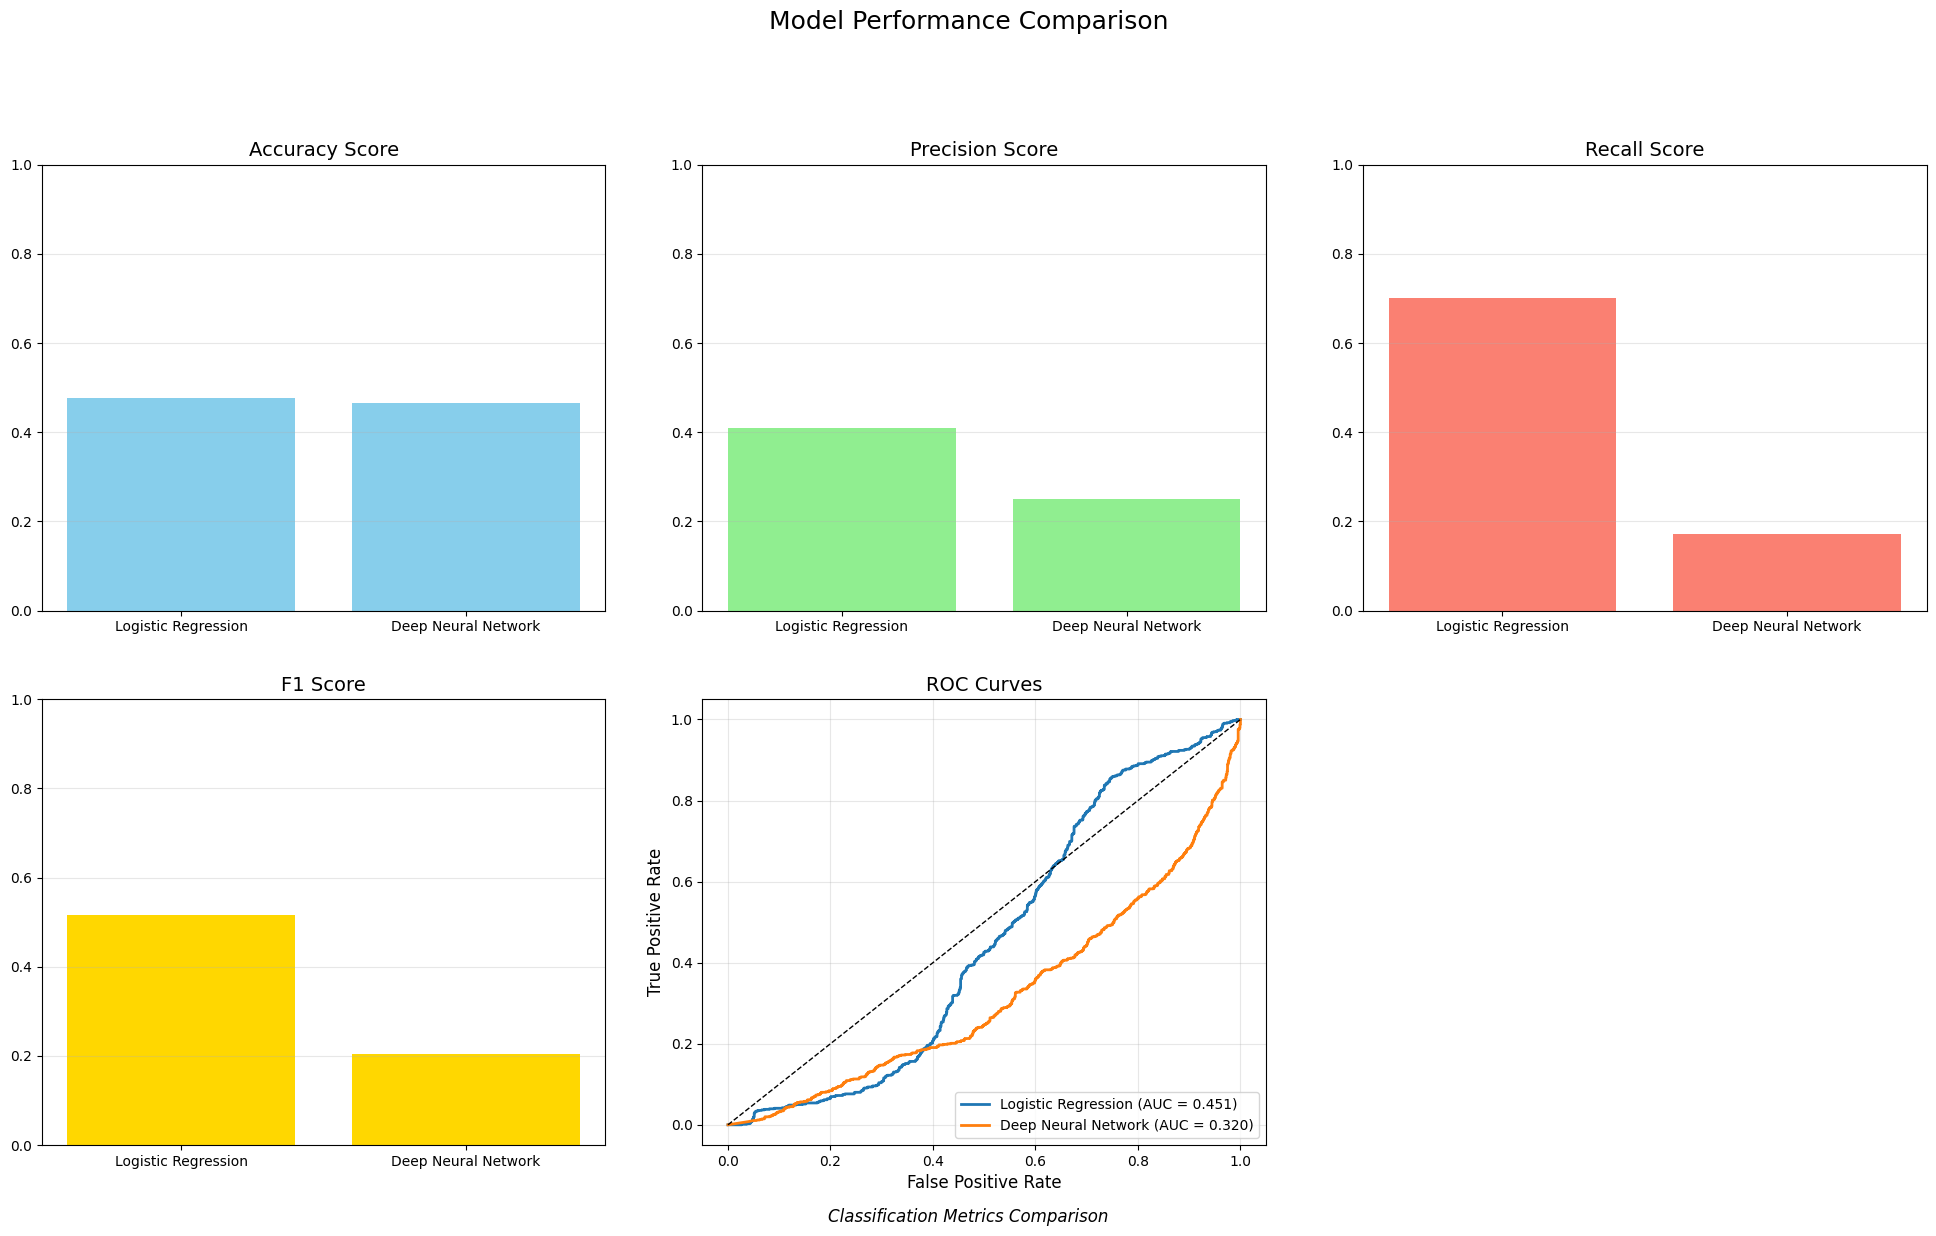

In [8]:
from src.plot_evaluation import PlotEvaluation

plots_config = [
    {
        "preds": [lr_pred, dnn_pred],
        "probas": [lr_proba, dnn_proba],
        "labels": ['Logistic Regression', 'Deep Neural Network']
    }]

for config in plots_config:
    plotter = PlotEvaluation(test['Toxicity'], config["preds"], config["probas"], config["labels"])
    plotter.plot_metrics()